# CIFAR-10 이미지 생성하기


In [1]:
import os
import glob
import time

import PIL
import imageio
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print(imageio.__version__)

tensorflow 2.6.0
2.9.0


In [38]:
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples

In [41]:
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints

In [42]:
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

### 데이터셋 가져오기
CIFAR-10 데이터셋도 tf.keras 안의 datasets에 포함되어있어서 가져올 수 있다.

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


1. 학습 데이터의 이미지를 정규화  
2. 학습 데이터 시각화  
3. tf.data.Dataset 모듈의 from_tensor_slices() 함수 사용 미니배치 데이터셋 구성

1. 학습 데이터 이미지 정규화 + 2. 학습 데이터 시각화

In [6]:
print('max pix : ', train_x.max())
print('min pix : ', train_x.min())

max pix :  255
min pix :  0


In [7]:
train_x = train_x / 255

print('max pix : ', train_x.max())
print('min pix : ', train_x.min())

max pix :  1.0
min pix :  0.0


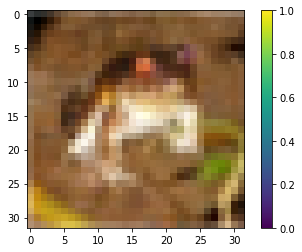

In [8]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

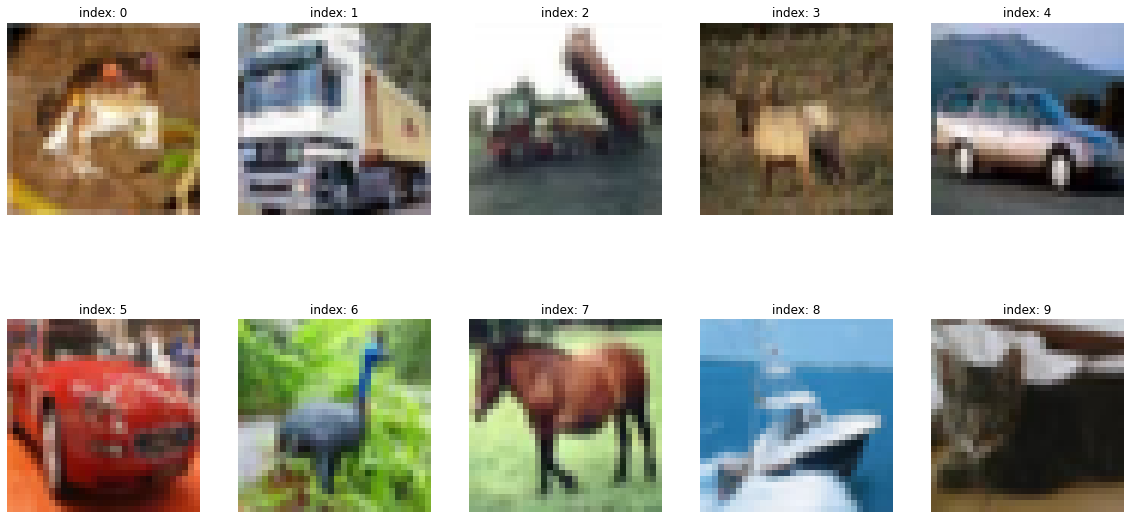

In [9]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [10]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [11]:
train_x = (train_x - 127.5) / 127.5

print('max pix : ', train_x.max())
print('min pix : ', train_x.min())

max pix :  1.0
min pix :  -1.0


data / 255와 (data-127.5) / 127.5의 차이는 정규화 범위가 달라진다
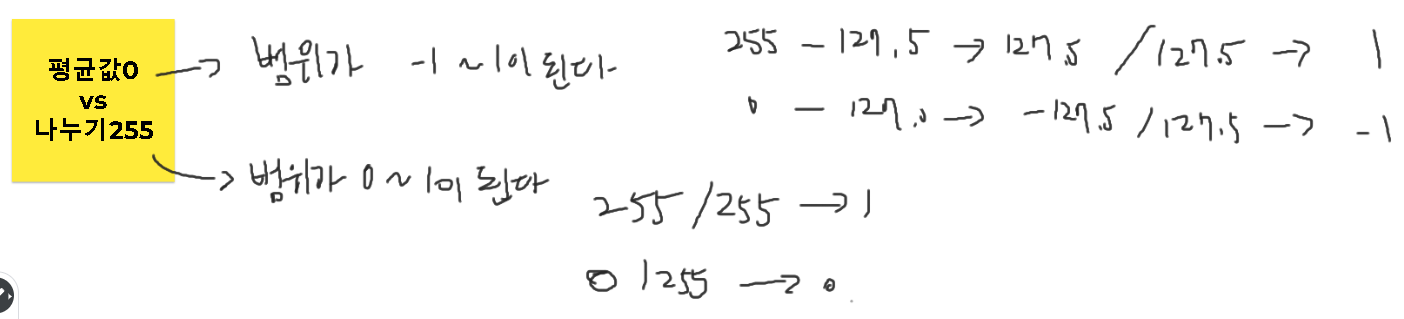

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


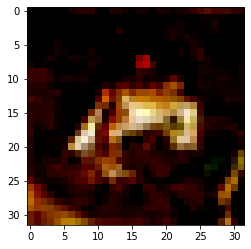

In [12]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.show()

인덱스 랜덤으로 지정하여 이미지 출력하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

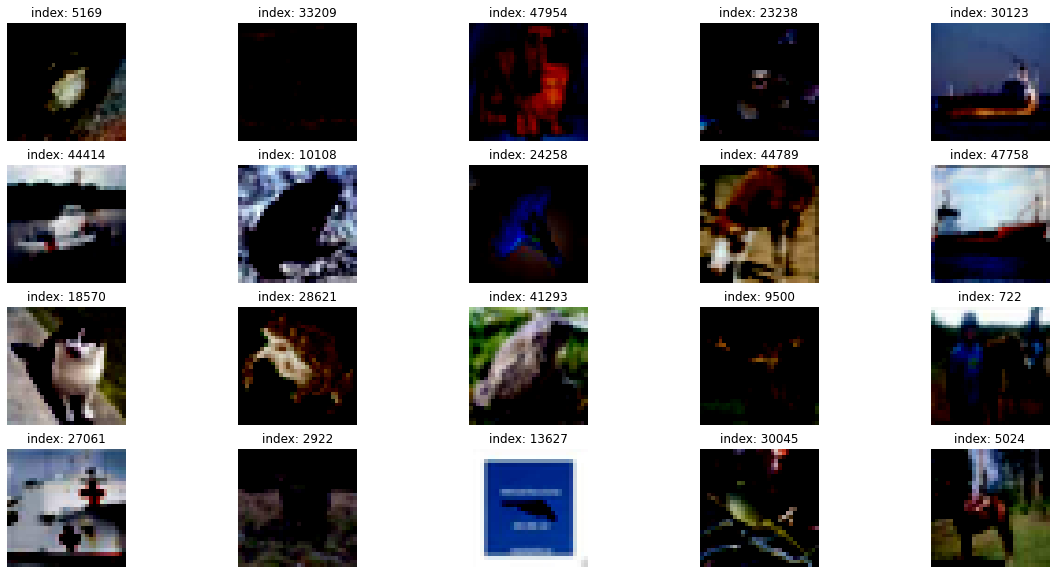

In [13]:
plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(4, 5, i+1)
    ri = np.random.randint(1,50000)
    plt.imshow(train_x[ri].reshape(32, 32, 3))
    plt.title(f'index: {ri}')
    plt.axis('off')
plt.show()

3. tf.data.Dataset 모듈의 from_tensor_slices() 함수 사용 미니배치 데이터셋 구성

In [14]:
# BUFFER_SIZE는 전체 데이터를 섞기 위한 수치 후에 shuffle()함수로 데이터셋을 섞어 모델에 넣어줌
BUFFER_SIZE = 50000
# BATCH_SIZE는 한번에 학습할 데이터 양
BATCH_SIZE = 128

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 리스트,넘파이,텐서 자료형에서 데이터셋을 만들 수 있음  
위는 train_x라는 np배열형 자료를 섞고, 배치 사이즈에 따라 나누도록 설계됨  
데이터가 잘 섞이려면 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는게 좋음

### 생성자 모델 구현하기
DCGAN(Deep Convolutional GAN)  
keras의 Sequential API 사용

In [16]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

tf.keras.Sequential()로 모델을 불러오고 레이어를 쌓아준다.  
중요한 레이어는 Conv2Dtranspose 레이어인데, 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 레이어이다.  
BatchNormalization 레이어는 신경망의 가중치가 안정적일 수 있도록 가중치 값을 정규화 시켜준다.  
활성화 함수는 Leaky ReLU 사용  
마지막 활성화 함수는 tanh -> 데이터의 픽셀 범위를 -1~1로 정규화시켰기에 범위가 같아 사용

In [17]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [18]:
# tf.random.narmal을 이용해서 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 만들기
noise = tf.random.normal([1, 100])

현재는 학습중이 아니므로 training=False로 지정해주고 해야한다  
batchNormalization레이어는 학습 시기와 추론 시기의 행동이 다르기때문에 잘 설정해주어야한다.

In [19]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

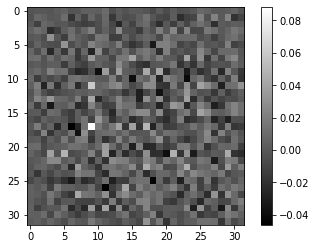

In [20]:
plt.imshow(generated_image[0, :, :, -1], cmap='gray')
plt.colorbar()
plt.show()

### 판별자 모델 설계하기
진짜 이미지와 가짜 이미지를 입력받으면 진짜라고 판단하는 값을 출력  
입력은 (32, 32, 3) 크기의 이미지이고, 출력은 하나의 숫자

In [21]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [22]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

생성자와는 반대로 Conv2D 레이어를 통해 이미지의 크기를 점점 줄여나간다.  
마지막은 Flatten 층을 사용하여 3차원 이미지를 1차원의 벡터로 변환시킨다. (8 * 8 * 128) -> 8192  

In [23]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00760173]], dtype=float32)>

### 손실값&정확도 구하기
GAN은 손실함수로 이진 교차 엔트로피를 사용한다 (진짜 or 가짜인지 판별)  
생성자 - 생성한 가짜 이미지를 판별자가 진짜라고 믿게 판단하도록 속이는게 목표  
판별자 - 생성자가 만든 가짜 이미지를 가짜라고, 진짜 이미지를 진짜라고 판단하는게 목표  
from_logits=True는 BinaryCrossentropy의 인풋값은 0~1 사이의 확률값이여야하는데  
판별자 모델의 마지막에는 시그모이드나 하이퍼탄젠트같은 활성화함수가 없어 출력값의 범위가 정해져있지않기 때문이다  
엔트로피에 입력된 값을 함수 내부에서 정규화 한 후 계산된다.

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

생성자 손실값  
생성자는 생성한 가짜 이미지가 진짜처럼 보이게 하길 바라므로  
fake_output이 1에 가깝게 하는게 목표이다  
tf.ones_like(fake_output)과 fake_output의 값이 비슷해질수록 손실값은 작아진다.

In [25]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

판별자 손실값  
판별자는 진짜 이미지를 1에 가깝도록, 가짜 이미지를 0에 가깝도록 하는게 목표  
두가지 손실값을 모두 계산하여 더한다

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

판별자 정확도  
real_output, fake_output을 따로 계산하여 비교  
real_acc와 fake_acc가 초반에는 1에 가깝게 나오다가, 조금씩 낮아져 각각 0.5에 가까워지는것이 이상적  
fake_acc가 1에 더 가깝다면 생성자가 판별자를 잘 속이지 못하고 있다는 뜻이라고 한다.

In [27]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

optimizer(최적화 함수)  
Adam 최적화 기법을 사용  
생성자와 판별자는 따로 학습을 진행하기때문에 optimizer도 따로 생성

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [29]:
# 임의의 수의 노이즈 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [30]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [31]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [32]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, -1])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [33]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [36]:
save_every = 5
EPOCHS = 50

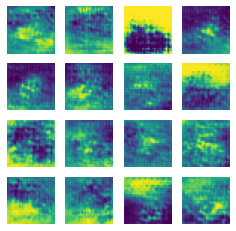

Time for training : 897 sec


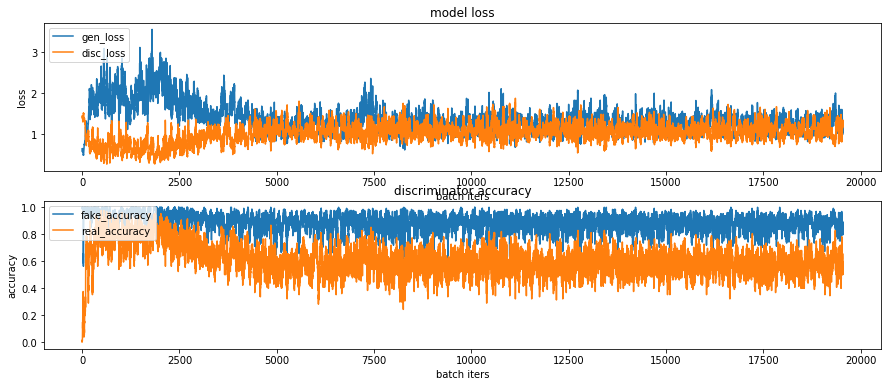

CPU times: user 16min 2s, sys: 1min 54s, total: 17min 56s
Wall time: 14min 59s


In [43]:
%%time
train(train_dataset, EPOCHS, save_every)

착한사람만 알아 볼 수 있는 이미지가 완성되었다.